source: https://github.com/ismailuddin/gradcam-tensorflow-2

In [1]:
import tensorflow as tf
from keras.models import load_model
import numpy as np

import cv2
import matplotlib.pyplot as plt
from PIL import Image

2022-11-27 21:29:33.668790: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 21:29:33.895027: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-27 21:29:33.963822: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-27 21:29:34.588261: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [2]:
model = load_model("../models/weights.23-0.0296-0.9963-0.2701-0.9408.h5")
model.summary()

2022-11-27 21:29:36.049515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-27 21:29:36.102313: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-27 21:29:36.102349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-27 21:29:36.102877: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the ap

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']       

2022-11-27 21:29:52.171024: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-27 21:29:54.114208: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-27 21:29:55.380683: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


tf.Tensor(
[[[[-2.55381519e-06  4.20340669e-08  1.31735732e-07 ...  2.97979591e-06
     1.97118989e-05  3.52486177e-06]
   [ 1.22966469e-06  5.91797800e-07  7.43843827e-07 ... -1.71648462e-05
    -9.78896151e-06  4.24117825e-05]
   [ 2.60283446e-06 -3.37049528e-07 -1.23125233e-06 ... -1.88094182e-05
     2.20619386e-05  5.19183732e-06]
   [-2.57040983e-06  3.68245878e-07  1.40056648e-06 ... -1.66324553e-05
     1.21150024e-05  4.18268864e-05]]

  [[ 7.14987607e-07 -8.61671140e-07 -2.26912425e-06 ...  1.15755665e-05
     1.73394819e-05 -1.32752748e-05]
   [ 1.28871447e-08  5.01701322e-07  3.67438219e-07 ... -2.24553187e-05
     2.01809107e-05  6.67840732e-06]
   [ 1.40742441e-06  4.40108266e-07 -1.65116273e-06 ... -3.03697907e-05
     2.79843553e-05 -1.34786269e-05]
   [ 1.21823621e-06  1.09110977e-06  2.27105602e-07 ... -1.93970427e-05
     1.32092036e-05  2.97142797e-05]]

  [[ 9.59642819e-08 -7.72630404e-09 -2.94206529e-06 ... -1.98440148e-06
     2.75789498e-05 -2.49248969e-05]
   [

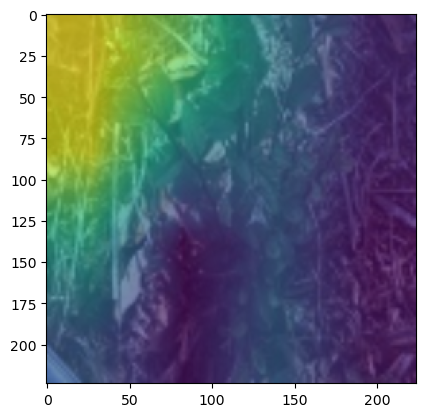

In [3]:
img = Image.open("../data/gradcam/densenet_correct_0.jpg")
img_array = np.asarray(img)

model = load_model("../models/weights.23-0.0296-0.9963-0.2701-0.9408.h5")
    
last_conv_layer = model.get_layer("relu")
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in ["flatten_1", "dense_1", "batch_normalization_1", "dropout_1", "predictions"]:
    x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

with tf.GradientTape() as tape:
    inputs = img_array[np.newaxis, ...]
    last_conv_layer_output = last_conv_layer_model(inputs)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]
    
grads = tape.gradient(top_class_channel, last_conv_layer_output)

print(grads)

pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
# Average over all the filters to get a single 2D array
gradcam = np.mean(last_conv_layer_output, axis=-1)
# Clip the values (equivalent to applying ReLU)
# and then normalise the values
gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
gradcam = cv2.resize(gradcam, (224, 224))
img = cv2.resize(img_array, (224,224))
plt.imshow(img)
plt.imshow(gradcam, alpha=0.7)

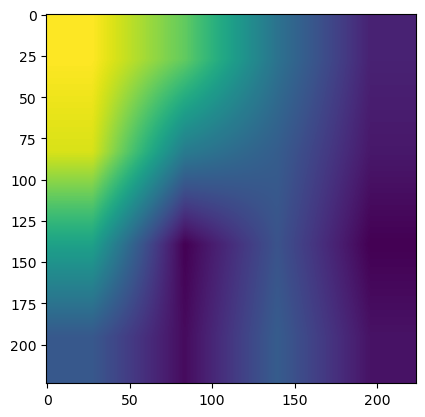

In [4]:
plt.imshow(gradcam)

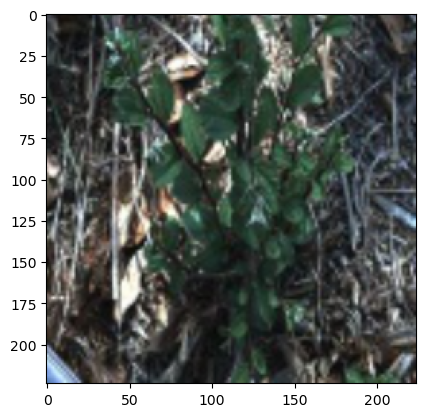

In [5]:
plt.imshow(img)